<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Phase-Curves-Part-1" data-toc-modified-id="Phase-Curves-Part-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Phase Curves Part 1</a></span><ul class="toc-item"><li><span><a href="#Run-Thermal-Phase-Curve-w/-3D-Input" data-toc-modified-id="Run-Thermal-Phase-Curve-w/-3D-Input-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Run Thermal Phase Curve w/ 3D Input</a></span></li><li><span><a href="#Analyze-Phase-Curves" data-toc-modified-id="Analyze-Phase-Curves-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Analyze Phase Curves</a></span></li><li><span><a href="#Run-Cloudy-Thermal-Phase-Curve-w/-3D-Input" data-toc-modified-id="Run-Cloudy-Thermal-Phase-Curve-w/-3D-Input-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Run Cloudy Thermal Phase Curve w/ 3D Input</a></span></li></ul></li></ul></div>

# Phase Curves Part 1

**Citation: [Robbins-Blanch et al. 2022 "Cloudy and Cloud-free Thermal Phase Curves with PICASO: Applications to WASP-43b" ApJ](http://arxiv.org/abs/2204.03545)**

From the previous two tutorials you should understand how: 

1. How to convert your GCM input to `PICASO`'s required `xarray`
2. How to post-process output to append to your GCM output

Here you will learn: 

1. How to compute a phase curve
2. How to analyze the resulting output

In [1]:
import pandas as pd
import numpy as np

from picaso import justdoit as jdi
from picaso import justplotit as jpi
jpi.output_notebook()

Loading BokehJS ...

## Run Thermal Phase Curve w/ 3D Input

Computing a phase curve is identical to computing 3D spectra. The only difference is that you will need to **rotate the GCM longitude grid such that the visible portion of the planet changes as the phase changes.** 

We can experiment with doing this with our original xarray input:

In [2]:
opacity = jdi.opannection(wave_range=[1,1.7])

In [3]:
gcm_out =  jdi.HJ_pt_3d(as_xarray=True)

### Add Chemistry (randomized for purposes of the example)

Add chemistry, if not already included in your GCM output. Here, we are using the user-defined input. 

In [4]:
# create coords
lon = gcm_out.coords.get('lon').values
lat = gcm_out.coords.get('lat').values
pres = gcm_out.coords.get('pressure').values

fake_chem_H2O = np.random.rand(len(lon), len(lat),len(pres))*0.1+0.1 # create fake data
fake_chem_H2 = 1-fake_chem_H2O # create data

# put data into a dataset
ds_chem = jdi.xr.Dataset(
    data_vars=dict(
        H2O=(["lon", "lat","pressure"], fake_chem_H2O,{'units': 'v/v'}),
        H2=(["lon", "lat","pressure"], fake_chem_H2,{'units': 'v/v'}),
    ),
    coords=dict(
        lon=(["lon"], lon,{'units': 'degrees'}), #required
        lat=(["lat"], lat,{'units': 'degrees'}), #required
        pressure=(["pressure"], pres,{'units': 'bar'})#required*
    ),
    attrs=dict(description="coords with vectors"),
)
all_gcm = gcm_out.update(ds_chem)

In [5]:
all_gcm

<xarray.Dataset>
Dimensions:      (lon: 128, lat: 64, pressure: 53)
Coordinates:
  * lon          (lon) float64 -180.0 -177.2 -174.4 -171.6 ... 171.6 174.4 177.2
  * lat          (lat) float64 -90.0 -87.19 -84.38 -81.56 ... 81.56 84.38 87.19
  * pressure     (pressure) float64 170.6 120.5 85.15 ... 3.42e-06 2.416e-06
Data variables:
    temperature  (lon, lat, pressure) float64 1.896e+03 1.809e+03 ... 750.7
    H2O          (lon, lat, pressure) float64 0.1771 0.1029 ... 0.168 0.1349
    H2           (lon, lat, pressure) float64 0.8229 0.8971 ... 0.832 0.8651
Attributes:
    description:  coords with vectors

Setup phase curve grid by defining the type of phase curve (thermal or reflected) as well as the phase angle grid. 

If you have not gone through the previous tutorials on xarray, post processing input, and computing 3D spectra, we highly recommend you look at that documentation. 

In [6]:
case_3d = jdi.inputs()
n_phases = 4
min_phase = 0 
max_phase = 2*np.pi
phase_grid = np.linspace(min_phase,max_phase,n_phases)#between 0 - 2pi
#send params to phase angle routine
case_3d.phase_angle(phase_grid=phase_grid, 
                    num_gangle=6, num_tangle=6,calculation='thermal')

### Determining the `zero_point` and the  `shift` parameter 

Starting assumptions: 
- User input lat=0, lon=0 is the substellar point and phase=0 is the nightside transit 

If you want to change the zero point use `zero_point`: 
- options for zero_point include: 'night_transit' (default) or 'secondary_eclipse'

For each orbital `phase`, `picaso` will rotate the longitude grid `phase_i`+`shift_i`. For example:
- For tidally locked planets `shift`=np.zeros(len(phases)). Meaning, the sub-stellar point never changes. 
- For non-tidally locked planets `shift` will depend on the eccentricity and orbital period of the planet 

`shift` must be input as an array of length `n_phase`. In this example, we will only explore tidally locked planets and will input a zero array. 


Use `plot=True` below to get a better idea of how your GCM grid is being shifted. 

/home/nbatalh1/anaconda3/envs/picaso38/lib/python3.8/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/nbatalh1/anaconda3/envs/picaso38/lib/python3.8/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


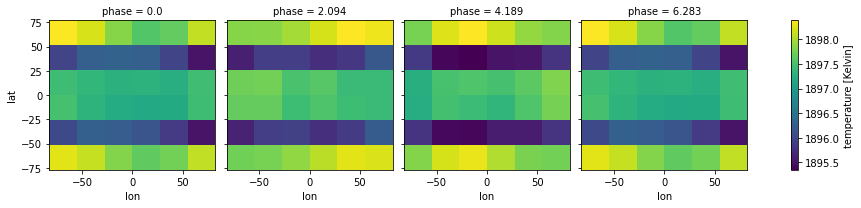

In [7]:
case_3d.atmosphere_4d(all_gcm, shift = np.zeros(n_phases), zero_point='night_transit',
                                     plot=True,verbose=False)

In [8]:
case_3d.inputs['atmosphere']['profile']

<xarray.Dataset>
Dimensions:      (phase: 4, pressure: 53, lat: 6, lon: 6)
Coordinates:
  * pressure     (pressure) float64 170.6 120.5 85.15 ... 3.42e-06 2.416e-06
  * lon          (lon) float64 -68.82 -41.39 -13.81 13.81 41.39 68.82
  * lat          (lat) float64 64.29 38.57 12.86 -12.86 -38.57 -64.29
  * phase        (phase) float64 0.0 2.094 4.189 6.283
Data variables:
    temperature  (phase, pressure, lat, lon) float64 1.898e+03 ... 550.3
    H2O          (phase, pressure, lat, lon) float64 0.1545 0.1299 ... 0.163
    H2           (phase, pressure, lat, lon) float64 0.8455 0.8701 ... 0.837
Attributes:
    description:    coords with vectors
    regrid_method:  bilinear

Easy plotting different phases with `xarray` functionality (remember our H2O selection was random, so the plot will not be to enlightening) 

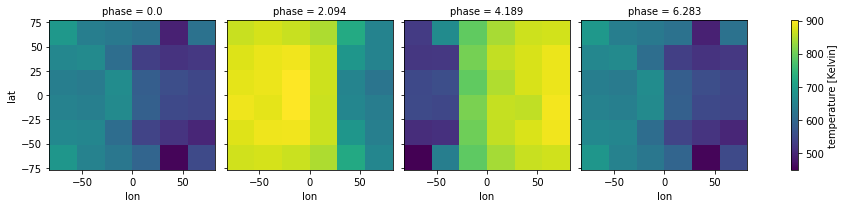

In [9]:
case_3d.inputs['atmosphere']['profile']['temperature'].isel(pressure=52).plot(
                                              x='lon', y ='lat',
                                              col='phase',col_wrap=4)

Set gravity and stellar parameters as usual

In [10]:
case_3d.gravity(radius=1,radius_unit=jdi.u.Unit('R_jup'), 
                mass=1, mass_unit=jdi.u.Unit('M_jup')) #any astropy units available
case_3d.star(opacity,5000,0,4.0, radius=1, radius_unit=jdi.u.Unit('R_sun')) 

All is setup. Proceed with phase curve calculation.

In [11]:
allout = case_3d.phase_curve(opacity, n_cpu = 3,#jdi.cpu_count(),
                             full_output=True)

## Analyze Phase Curves

All original plotting tools still work by selecting an individual phase

In [12]:
#same old same old
wno =[];fpfs=[];legend=[]
for iphase in allout.keys():
    w,f = jdi.mean_regrid(allout[iphase]['wavenumber'],
                               allout[iphase]['fpfs_thermal'],R=100)
    wno+=[w]
    fpfs+=[f*1e6]
    legend +=[str(int(iphase*180/np.pi))]
jpi.show(jpi.spectrum(wno, fpfs, plot_width=500,legend=legend,
                     palette=jpi.pals.viridis(n_phases)))

### Phase Curve Plotting Tools: Phase Snaps

Phase snaps allows you to show snapshots of what is happening at each phase that was computed. x,y,z axes can be swapped out for flexibility. 

- Allowable x: `'longitude', 'latitude', 'pressure'`
- Allowable y: `'longitude', 'latitude', 'pressure'` 
- Allowable z: `'temperature','taugas','taucld','tauray','w0','g0','opd'` (*the latter three are cloud properties*)
- Allowable collapse: 
    Collapse tells picaso what to do with the extra axes. For instance, taugas is an array that is `[npressure,nwavelength,nlongitude,nlatitude]`. If we want `pressure x latitude` we have to collapse wavelength and the longitude axis. To do so we could either supply an integer value to select a single dimension. Or we could supply one of the following as `str` input: [np.mean, np.median, np.min, np.max]. If there are multiple axes you want to collapse, supply an ordered list. 

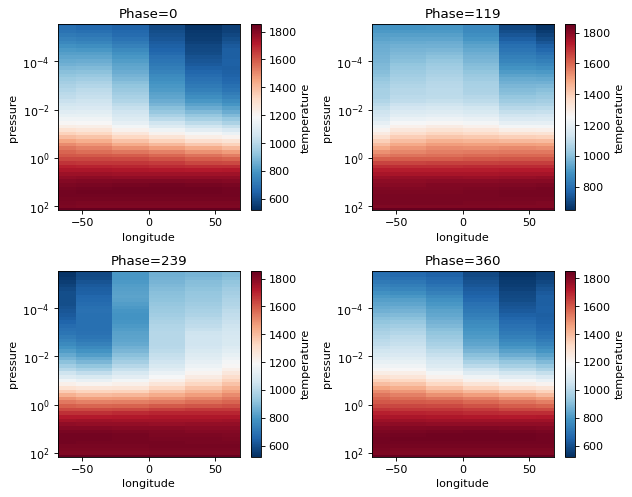

In [13]:
fig=jpi.phase_snaps(allout, x='longitude', y='pressure',z='temperature', 
                y_log=True, z_log=False, collapse='np.mean')#this will collapse the latitude axis by taking a mean

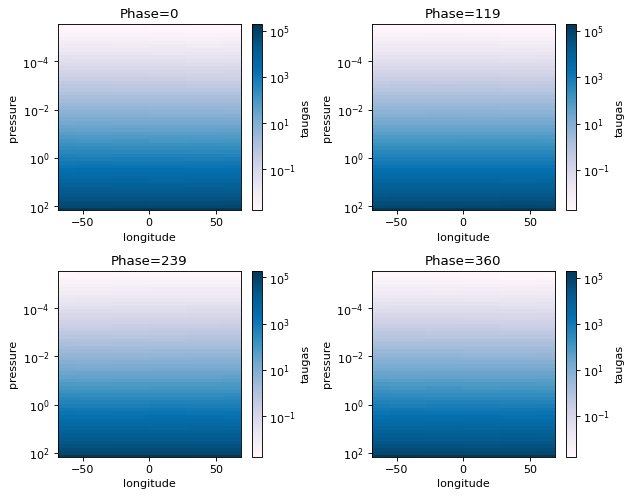

In [14]:
fig=jpi.phase_snaps(allout, x='longitude', y='pressure',z='taugas', palette='PuBu',
                y_log=True, z_log=True, collapse=['np.mean','np.mean'])
#this will collapse the latitude axis by taking a mean, and the wavelength axis also by taking the mean

Pressure at 0.0030016929695969906


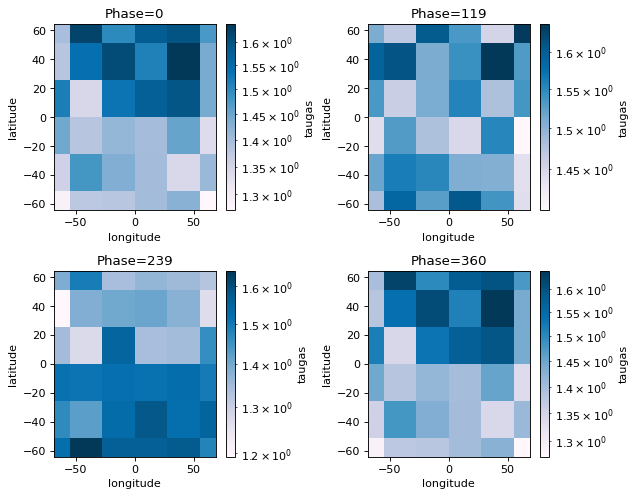

In [15]:
fig=jpi.phase_snaps(allout, x='longitude', y='latitude',z='taugas', palette='PuBu',
                y_log=False, z_log=True, collapse=[20,'np.mean'])
#this will collapse the pressure axis by taking the 20th pressure grid point 
#and the wavelength axis by taking the mean
print('Pressure at', allout[iphase]['full_output']['layer']['pressure'][20,0,0])

### Phase Curve Plotting Tools: Phase Curves

We can use the same `collapse` feature as in the `phase_snaps` tool to collapse the wavelength axis, when plotting phase curves. For example, we can select a single wavelength point at a given resolution, or we can average over all wavelengths. 

Allowable collapse: 
- `'np.mean'` or `np.sum`
- float or list of float: wavelength in microns (will find the nearest value to this wavelength). Must be in wavenumber range. 

For `float` option, user must specify resolution. 

In [16]:
to_plot = 'fpfs_thermal'#or thermal 
collapse = [1.1,1.4,1.6]#micron
R=100
phases, all_curves, all_ws, fig=jpi.phase_curve(allout, to_plot, collapse=collapse, R=100)
jpi.show(fig)

## Run Cloudy Thermal Phase Curve w/ 3D Input

Here we will create a hypothetical cloud path and add it to our fake H2O profile to demonstrate the basics of running a cloudy phase curve

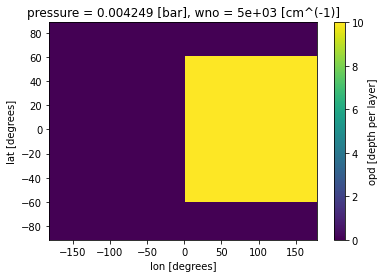

In [17]:
# create coords
lon = all_gcm.coords.get('lon').values
lat = all_gcm.coords.get('lat').values
pres = all_gcm.coords.get('pressure').values
pres_layer = np.sqrt(pres[0:-1]*pres[1:])
wno_grid = np.linspace(1e4/2,1e4/1,10)#cloud properties are defined on a wavenumber grid

#create box-band cloud model 
fake_opd = np.zeros((len(lon), len(lat),len(pres_layer), len(wno_grid))) # create fake data
where_lat = np.where(((lat>-60) & (lat<60)))#creating a grey cloud path
where_lon = np.where(lon>0)#creating a grey cloud path
where_pres = np.where(((pres_layer<0.01) & (pres_layer>1e-4)))#creating a grey cloud band 

for il in where_lat[0]:
    for ip in where_pres[0]:
        for ilo in where_lon[0]:
            fake_opd[ilo,il,ip,:]=10 #optical depth of 10 (>>1)

#make up asymmetry and single scattering properties 
fake_asymmetry_g0 = 0.8+ np.zeros((len(lon), len(lat),len(pres_layer), len(wno_grid))) 
fake_ssa_w0 = 0.9+ np.zeros((len(lon), len(lat),len(pres_layer), len(wno_grid))) 

# put data into a dataset
ds_cld= jdi.xr.Dataset(
    data_vars=dict(
        opd=(["lon", "lat","pressure","wno"], fake_opd,{'units': 'depth per layer'}),
        g0=(["lon", "lat","pressure","wno"], fake_asymmetry_g0,{'units': 'none'}),
        w0=(["lon", "lat","pressure","wno"], fake_ssa_w0,{'units': 'none'}),
    ),
    coords=dict(
        lon=(["lon"], lon,{'units': 'degrees'}),#required
        lat=(["lat"], lat,{'units': 'degrees'}),#required
        pressure=(["pressure"], pres_layer,{'units': 'bar'}),#required
        wno=(["wno"], wno_grid,{'units': 'cm^(-1)'})#required for clouds
    ),
    attrs=dict(description="coords with vectors"),
)
ds_cld['opd'].isel(pressure=30,wno=0).plot(x='lon',y='lat')

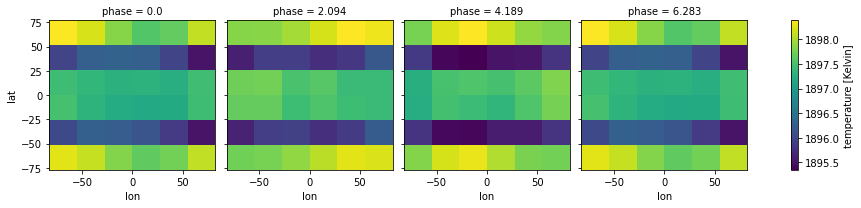

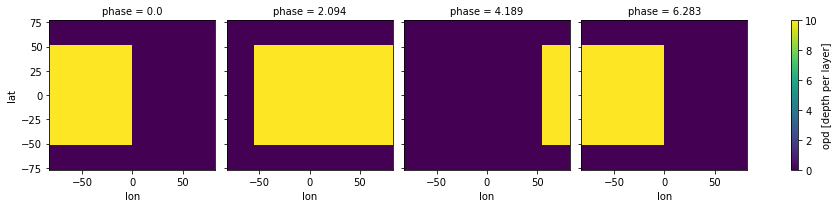

In [18]:
case_cld = jdi.inputs()
#setup geometry of run
n_phases = 4
min_phase = 0 
max_phase = 2*np.pi
phase_grid = np.linspace(min_phase,max_phase,n_phases)#between 0 - 2pi
#send params to phase angle routine
case_cld.phase_angle(phase_grid=phase_grid, 
                    num_gangle=6, num_tangle=6,calculation='thermal')

#setup 4d atmosphere 
case_cld.atmosphere_4d(all_gcm, shift = np.zeros(n_phases), zero_point='night_transit',
                                     plot=True,verbose=False)
#no need to input shift here, it will take it from atmosphere_4d
#in fact, clouds_4d must always be run AFTER atmosphere_4d
case_cld.clouds_4d(ds_cld, iz_plot=30,
                                     plot=True,verbose=False)
#same old planet and star properties
case_cld.gravity(radius=1,radius_unit=jdi.u.Unit('R_jup'), 
                mass=1, mass_unit=jdi.u.Unit('M_jup')) #any astropy units available
case_cld.star(opacity,5000,0,4.0, radius=1, radius_unit=jdi.u.Unit('R_sun')) 



Run cloudy phase curve!

In [19]:
cldout = case_cld.phase_curve(opacity, n_cpu = 3,#jdi.cpu_count(),
                             full_output=True)

In [20]:
#same old same old
wno =[];fpfs=[];legend=[]
for iphase in cldout.keys():
    w,f = jdi.mean_regrid(cldout[iphase]['wavenumber'],
                               cldout[iphase]['fpfs_thermal'],R=100)
    wno+=[w]
    fpfs+=[f*1e6]
    legend +=[str(int(iphase*180/np.pi))]
jpi.show(jpi.spectrum(wno, fpfs, plot_width=500,legend=legend,
                     palette=jpi.pals.viridis(n_phases)))

In [21]:
to_plot = 'fpfs_thermal'#or thermal 
collapse = [1.1,1.4,1.6]#micron
R=100
phases, all_curves, all_ws, fig=jpi.phase_curve(cldout, to_plot, collapse=collapse, R=100)
jpi.show(fig)

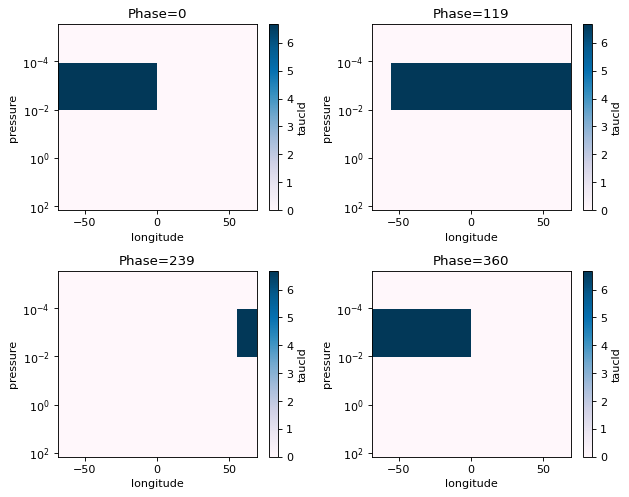

In [22]:
fig=jpi.phase_snaps(cldout, x='longitude', y='pressure',z='taucld', palette='PuBu',
                y_log=True, z_log=False, collapse=['np.max','np.mean'])
#this will collapse the latitude axis by taking a mean, and the wavelength axis also by taking the mean

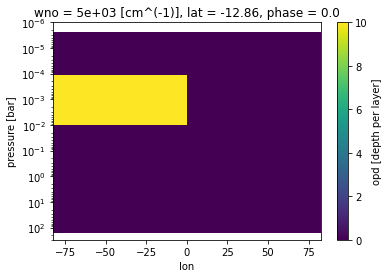

In [23]:
fig, ax = jpi.plt.subplots(figsize=(6, 4))
case_cld.inputs['clouds']['profile']['opd'].isel(phase=0,
    lat=3,wno=0).plot(
    x='lon',y='pressure',ax=ax)
ax.set_ylim([3e2,1e-6])
ax.set_yscale('log')